### Install

In [ ]:
!pip install gmft -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 14.3 MB/s eta 0:00:00


In [1]:
!pip show gmft

Name: gmft
Version: 0.3.2
Summary: Lightweight, performant, deep table extraction
Home-page: 
Author: conjunct, conjuncts
Author-email: 
License: 
Location: /home/jonah/table_extraction/gmft/venv/lib/python3.9/site-packages
Requires: tabulate, pypdfium2, pillow, pandas, matplotlib, torch, transformers
Required-by: 


In [1]:
import importlib
import gmft
import gmft.table_detection
import gmft.table_visualization
import gmft.table_function
import gmft.table_function_algorithm
import gmft.table_captioning
import gmft.pdf_bindings.bindings_pdfium
import gmft.pdf_bindings
import gmft.common

importlib.reload(gmft)
importlib.reload(gmft.common)
importlib.reload(gmft.table_captioning)
importlib.reload(gmft.table_detection)
importlib.reload(gmft.table_visualization)
importlib.reload(gmft.table_function)
importlib.reload(gmft.table_function_algorithm)
importlib.reload(gmft.pdf_bindings.bindings_pdfium)
importlib.reload(gmft.pdf_bindings)

<module 'gmft.pdf_bindings' from '/home/jonah/table_extraction/gmft/venv/lib64/python3.9/site-packages/gmft/pdf_bindings/__init__.py'>

### Paper 1: TATR

We will use the original paper that introduced the Table Transformer (TATR): "PubTables-1M: Towards comprehensive table extraction from unstructured documents" by Smock, Pesala, and Abraham.

In [3]:
# get the PubTables-1M paper, source of original Table Transformer (TATR)
!mkdir ./samples
!wget -O ./samples/tatr.pdf -q https://arxiv.org/pdf/2110.00061

In [2]:
from gmft.pdf_bindings import PyPDFium2Document
from gmft.auto import CroppedTable, AutoTableDetector

detector = AutoTableDetector()

def ingest_pdf(pdf_path) -> list[CroppedTable]:
    doc = PyPDFium2Document(pdf_path)

    tables = []
    for page in doc:
        tables += detector.extract(page)
    return tables, doc


In [3]:
tables, doc = ingest_pdf('./samples/finra2-short.pdf')
len(tables)

3

There are 6 matches. Let's view them.

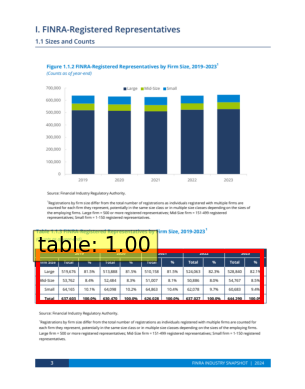

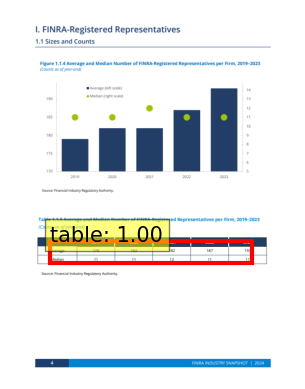

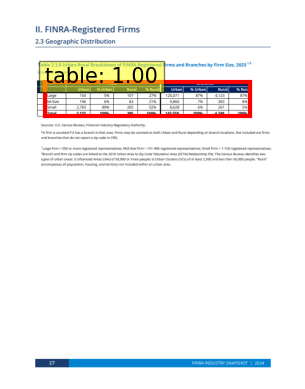

In [14]:
# display several images
# decrease size with plt
for table in tables:
    table.visualize(figsize=None)

In gmft, a `CroppedTable` is a region where a table has been detected. However, for speed, the text is not automatically extracted. To do this, you will need a `TableFormatter`. Specifically, the `AutoTableFormatter` is recommended (which currently points to `TATRTableFormatter`).

Let's work through the tables in order.

In [5]:
from gmft.auto import AutoTableFormatter

formatter = AutoTableFormatter()

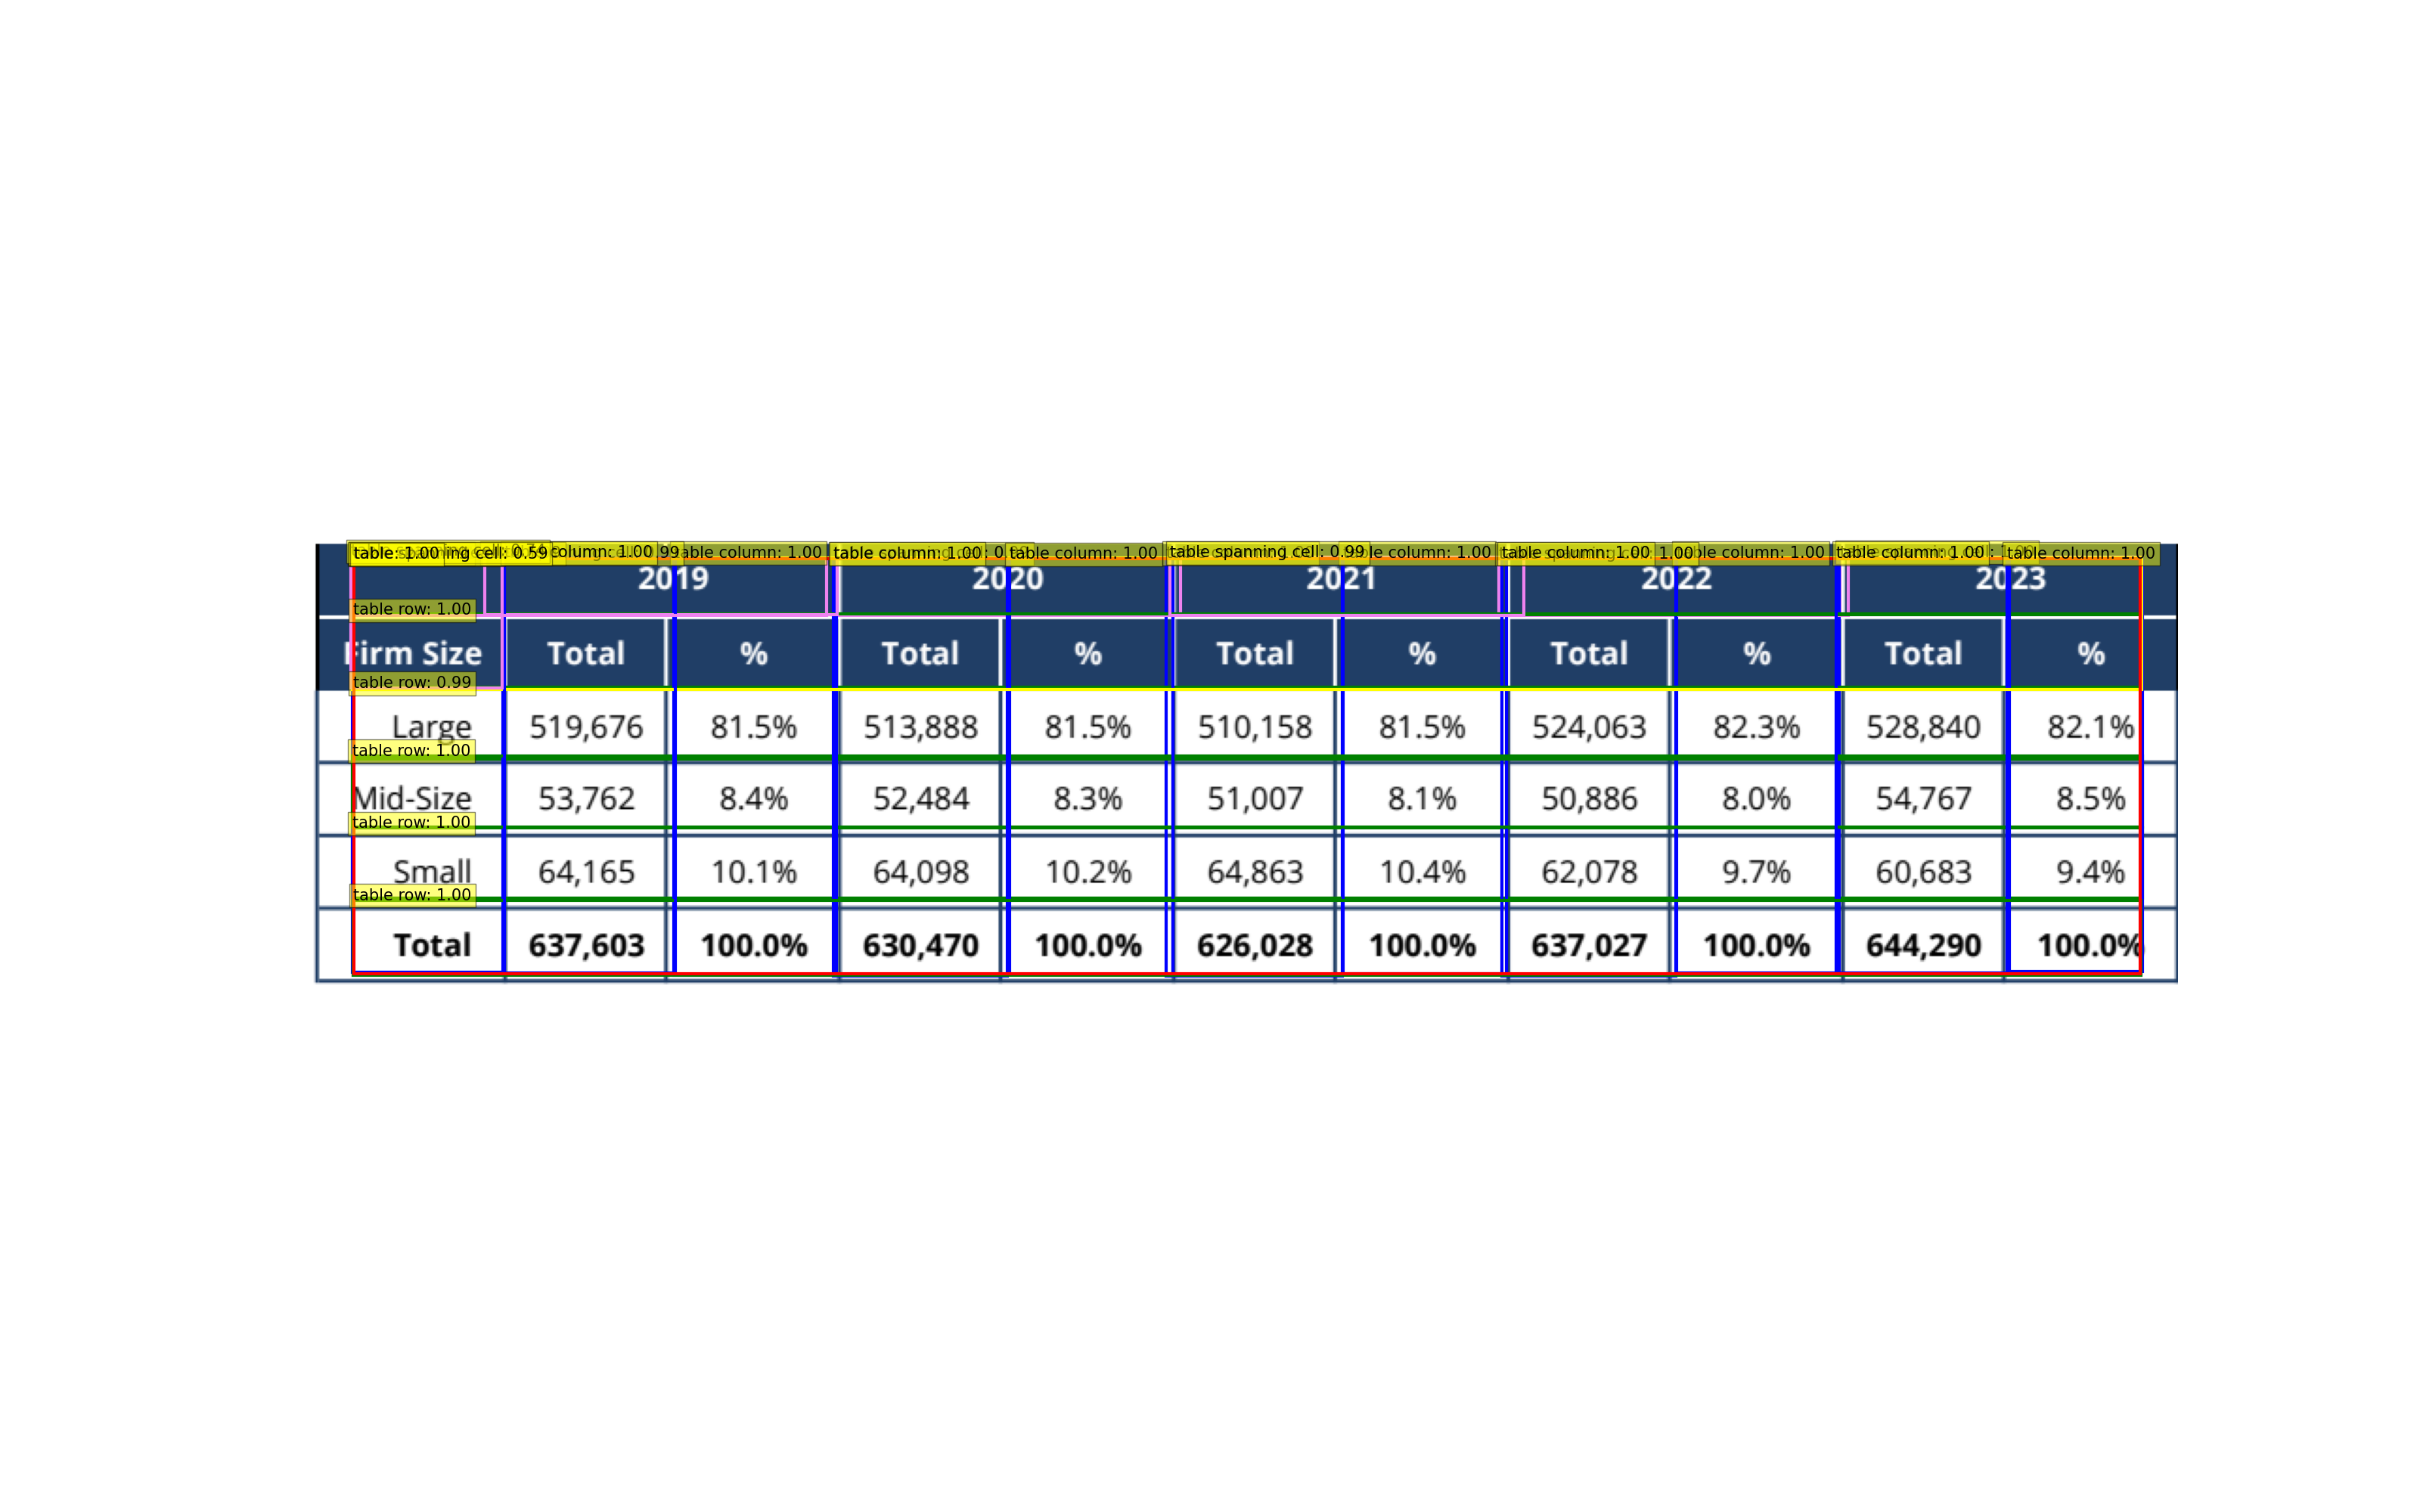

In [6]:
ft = formatter.extract(tables[0])
ft.visualize()

Since table #1 is an **image**, OCR is required (which you must handle externally.) The image can be obtained through ft.image(), which is a PIL image. This image can then be fed into an OCR of your choice, like paddlepaddle, tesseract, even GPT4 vision, etc.

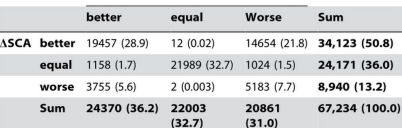

In [9]:
ft.image(dpi=144)

Let's keep going.

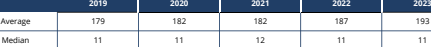

In [7]:
ft = formatter.extract(tables[1])
ft.image()

In [8]:
ft.df()

2019 2020 2021 2022 2023
0  Average  179  182  182  187  193
1   Median   11   11   12   11   11

Now that table has text, gmft can extract. You can call `table.text()` and `table.text_positions()` to, for instance, to filter results by keyword before parsing the table.

In [9]:
tables[1].text()

'2019 2020 2021 2022 2023\nAverage 179 182 182 187 193\nMedian 11 11 12 11 11'

New in `v0.2`, gmft can also detect table captions.

In [10]:
tables[1].captions()

('Table 1.1.5 Average and Median Number of FINRA-Registered Representatives per Firm, 2019–2023 (Counts as of year-end)',
 'Source: Financial Industry Regulatory Authority.')

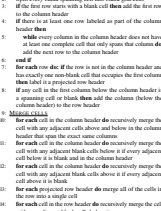

In [14]:
# 1s
ft = formatter.extract(tables[2])
ft.image(dpi=50)

It looks like table #3 is a false positive. The confidence score is also lower.

In [11]:
tables[2].label, tables[2].confidence_score

(0, 0.9991000890731812)

Undeterred, let's see table #4. 

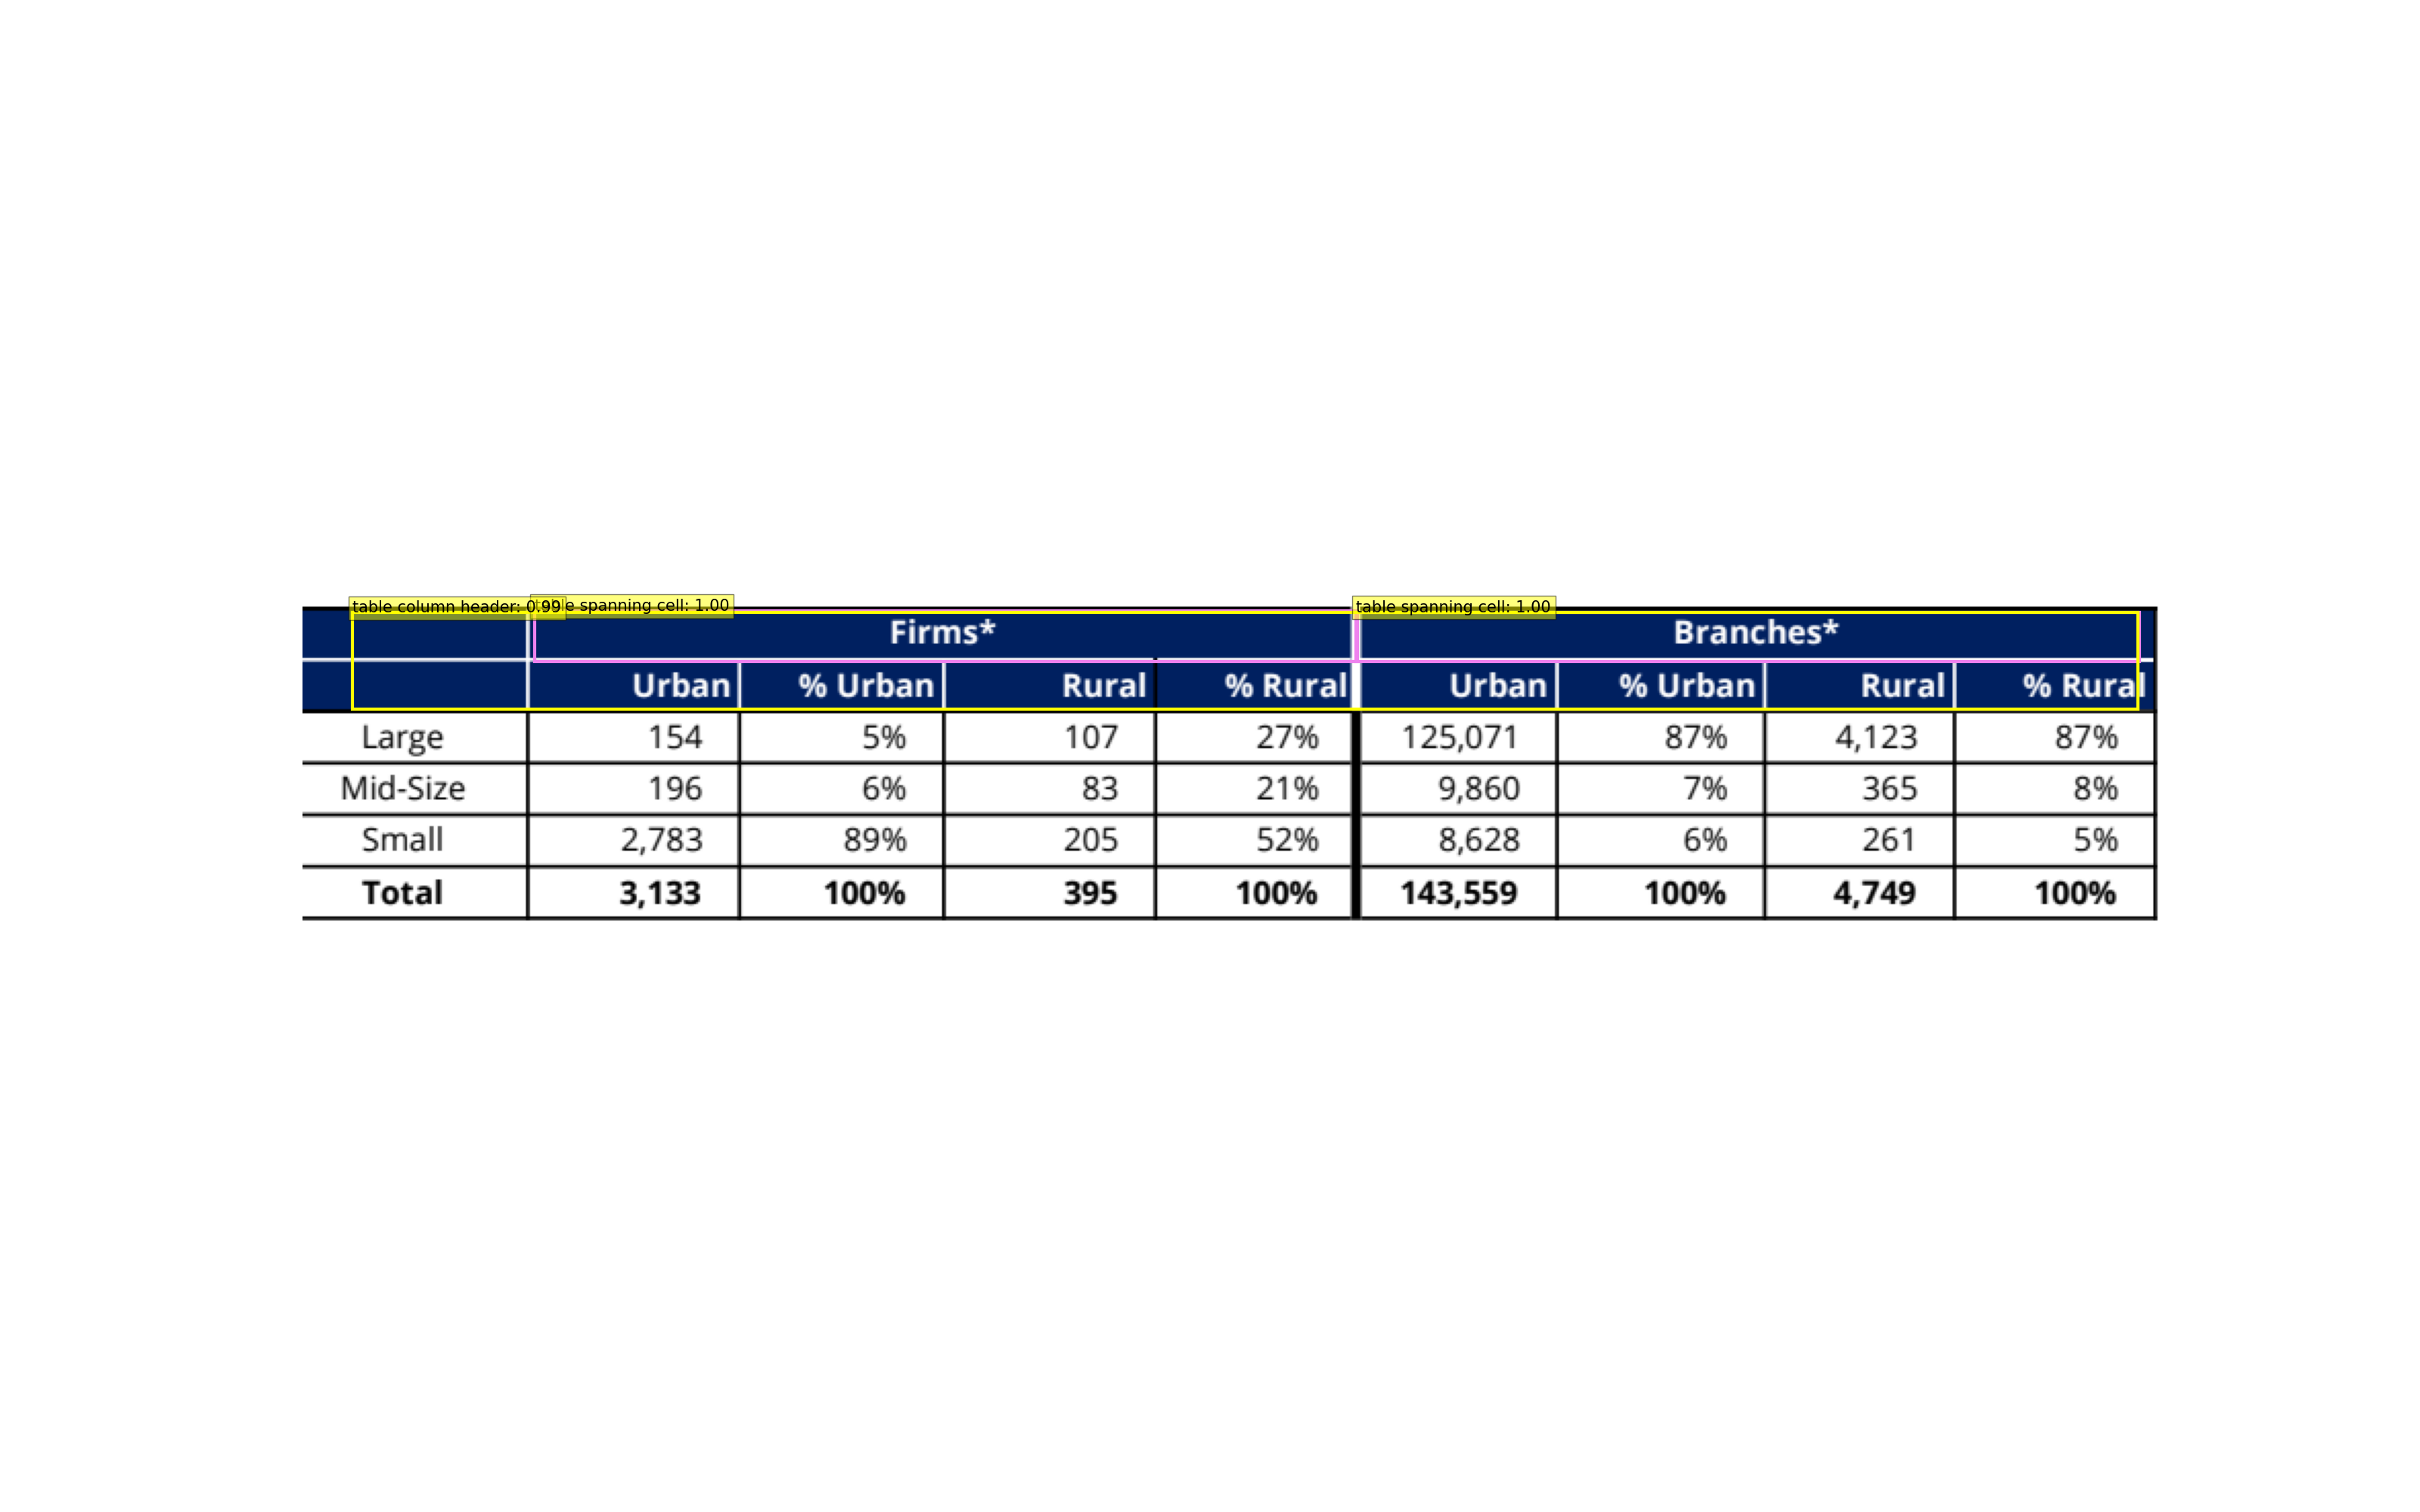

Urban Firms* \n% Urban Rural % Rural    Urban  \
0     Large    154               5%   107     27%  125,071   
1  Mid-Size    196               6%    83     21%    9,860   
2     Small  2,783              89%   205     52%    8,628   
3     Total  3,133             100%   395    100%  143,559   

  Branches* \n% Urban  Rural % Rural  
0                 87%  4,123     87%  
1                  7%    365      8%  
2                  6%    261      5%  
3                100%  4,749    100%

In [13]:
from IPython.display import display

ft = formatter.extract(tables[2])
display(ft.visualize(filter=[3, 5]))
ft.df()

There is a hierarchical header. New in `v0.2`, gmft can handle this. 

In [15]:
from gmft.auto import AutoFormatConfig


config_hdr = AutoFormatConfig() # config may be passed like so
config_hdr.verbosity = 3
config_hdr.enable_multi_header = True
config_hdr.semantic_spanning_cells = True # [Experimental] Merge headers

In [16]:
import pandas as pd

with pd.option_context('display.multi_sparse', False):
    display(ft.df(config_overrides=config_hdr))

Removed 1 overlapping rows


Header 2       NaN Firms*  Firms* Firms*  Firms* Branches* Branches*  \
Header 1       NaN  Urban % Urban  Rural % Rural     Urban   % Urban   
0            Large    154      5%    107     27%   125,071       87%   
1         Mid-Size    196      6%     83     21%     9,860        7%   
2            Small  2,783     89%    205     52%     8,628        6%   
3            Total  3,133    100%    395    100%   143,559      100%   

Header 2 Branches* Branches*  
Header 1     Rural   % Rural  
0            4,123       87%  
1              365        8%  
2              261        5%  
3            4,749      100%

Config overrides can also be passed into the formatter.

In [26]:
config = AutoFormatConfig() # config may be passed like so
config.verbosity = 3
config.enable_multi_header = False # This option disables pandas multi-headers
config.semantic_spanning_cells = True # But spanning cells can still be semantically analyzed
custom_formatter = AutoTableFormatter(config=config)

In [28]:
ft = custom_formatter.extract(tables[3])
ft.df()

Dataset Total Tables \nInvestigated†  \
0               SciTSR                       10,431   
1            PubTabNet                      422,491   
2            FinTabNet                       70,028   
3  PubTables-1M (ours)                      761,262   

  Total Tables \nwith a PRH∗ Tables with an oversegmented PRH \nTotal  \
0                        342                                       54   
1                    100,159                                   58,747   
2                     25,637                                   25,348   
3                    153,705                                        0   

  Tables with an oversegmented PRH \n% (of total with a PRH)  \
0                                             15.79%           
1                                             58.65%           
2                                             98.87%           
3                                                 0%           

  Tables with an oversegmented PRH \n% (of total investigated)  
0                                              0.52%            
1                                             13.90%            
2                                             36.20%            
3                                                 0%

Tables #5 is straightforward.

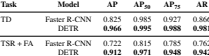

Task         Model     AP   AP50   AP75     AR
0        TD  Faster R-CNN  0.825  0.985  0.927  0.866
1      None          DETR  0.966  0.995  0.988  0.981
2  TSR + FA  Faster R-CNN  0.722  0.815  0.785  0.762
3      None          DETR  0.912  0.971  0.948  0.942

In [29]:
ft = formatter.extract(tables[4])
display(ft.image())
ft.df()

Table #6 has a hierarchical left header, now supported in `v0.2`. Relevant config settings are `TATRFormatConfig.semantic_spanning_cells=True` and `TATRFormatConfig.semantic_hierarchical_left_fill`

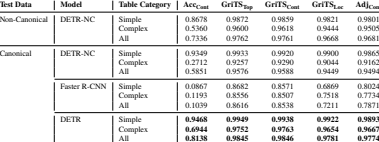

Test Data         Model Table Category AccCont GriTSTop GriTSCont  \
0   Non-Canonical       DETR-NC         Simple  0.8678   0.9872    0.9859   
1   Non-Canonical       DETR-NC        Complex  0.5360   0.9600    0.9618   
2   Non-Canonical       DETR-NC            All  0.7336   0.9762    0.9761   
3       Canonical       DETR-NC         Simple  0.9349   0.9933    0.9920   
4       Canonical       DETR-NC        Complex  0.2712   0.9257    0.9290   
5       Canonical       DETR-NC            All  0.5851   0.9576    0.9588   
6       Canonical  Faster R-CNN         Simple  0.0867   0.8682    0.8571   
7       Canonical  Faster R-CNN        Complex  0.1193   0.8556    0.8507   
8       Canonical  Faster R-CNN            All  0.1039   0.8616    0.8538   
9       Canonical          DETR         Simple  0.9468   0.9949    0.9938   
10      Canonical          DETR        Complex  0.6944   0.9752    0.9763   
11      Canonical          DETR            All  0.8138   0.9845    0.9846   

   GriTSLoc AdjCont  
0    0.9821  0.9801  
1    0.9444  0.9505  
2    0.9668  0.9681  
3    0.9900  0.9865  
4    0.9044  0.9162  
5    0.9449  0.9494  
6    0.6869  0.8024  
7    0.7518  0.7734  
8    0.7211  0.7871  
9    0.9922  0.9893  
10   0.9654  0.9667  
11   0.9781  0.9774

In [43]:
ft = formatter.extract(tables[5])
display(ft.image())
ft.df(config_overrides=config_hdr)

Important! With PyPDFium2, remember to close documents once you're done. This is especially important in loops.

In [33]:
doc.close()

### Paper 2: Attention

Let's look at the classic paper [Attention is All You Need](https://arxiv.org/abs/1706.03762) by Viswani et al.

In [ ]:
!wget -O ./samples/attention.pdf -q https://arxiv.org/pdf/1706.03762

In [44]:
tables, doc = ingest_pdf('./samples/attention.pdf')
len(tables)

5

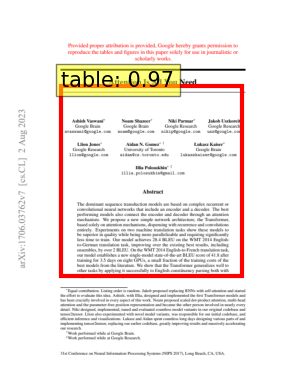

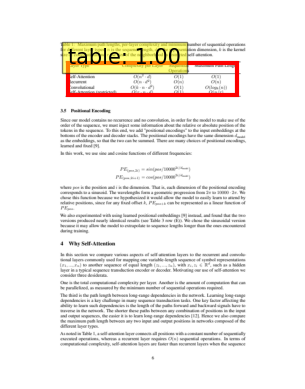

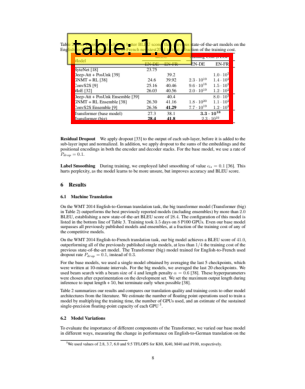

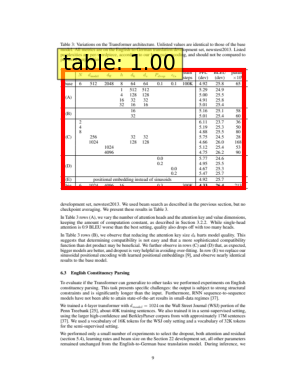

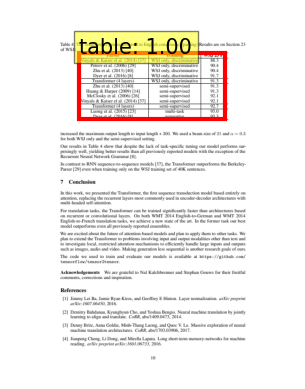

In [35]:
# display several images
# decrease size with plt
for table in tables:
    table.visualize(figsize=None)

In [36]:
ft = formatter.extract(tables[1])
ft.df()

Layer Type Complexity per Layer Sequential Operations  \
0               Self-Attention           O(n 2 · d)                  O(1)   
1                    Recurrent          O(n · d 2 )                  O(n)   
2                Convolutional      O(k · n · d 2 )                  O(1)   
3  Self-Attention (restricted)         O(r · n · d)                  O(1)   

  Maximum Path Length  
0                O(1)  
1                O(n)  
2          O(logk(n))  
3              O(n/r)

In [46]:
ft = formatter.extract(tables[2])
with pd.option_context('display.multi_sparse', False):
    display(ft.df(config_overrides=config_hdr))

Removed 1 overlapping rows


Header 2                              NaN   BLEU   BLEU Training Cost (FLOPs)  \
Header 1                            Model  EN-DE  EN-FR                 EN-DE   
0                            ByteNet [18]  23.75   None                  None   
1                  Deep-Att + PosUnk [39]   None   39.2                  None   
2                          GNMT + RL [38]   24.6  39.92            2.3 · 1019   
3                             ConvS2S [9]  25.16  40.46            9.6 · 1018   
4                                MoE [32]  26.03  40.56            2.0 · 1019   
5         Deep-Att + PosUnk Ensemble [39]   None   40.4                  None   
6                 GNMT + RL Ensemble [38]  26.30  41.16            1.8 · 1020   
7                    ConvS2S Ensemble [9]  26.36  41.29            7.7 · 1019   
8                Transformer (base model)   27.3   38.1                 3.3 ·   
9                       Transformer (big)   28.4   41.8                 2.3 ·   

Header 2 Training Cost (FLOPs) is_projecting_row  
Header 1                 EN-FR                    
0                         None              True  
1                   1.0 · 1020             False  
2                   1.4 · 1020             False  
3                   1.5 · 1020             False  
4                   1.2 · 1020             False  
5                   8.0 · 1020             False  
6                   1.1 · 1021             False  
7                   1.2 · 1021             False  
8                         1018             False  
9                         1019             False

In [39]:
ft = formatter.extract(tables[3])
ft.df().fillna('')

N dmodel         dff          h   dk          dv      Pdrop  ϵls  \
0   base  6    512        2048          8   64          64        0.1  0.1   
1                                       1  512         512                   
2                                       4  128         128                   
3    (A)                               16   32          32                   
4                                      32   16          16                   
5                                           16                               
6    (B)                                    32                               
7         2                                                                  
8         4                                                                  
9         8                                                                  
10   (C)       256                          32          32                   
11            1024                         128         128                   
12                        1024                                               
13                        4096                                               
14                                                                0.0        
15                                                                0.2        
16   (D)                                                               0.0   
17                                                                     0.2   
18   (E)            positional  embedding       instead of  sinusoids        
19   big  6   1024        4096         16                         0.3        

   train steps PPL (dev) BLEU (dev) params ×106  
0         100K      4.92       25.8          65  
1                   5.29       24.9              
2                   5.00       25.5              
3                   4.91       25.8              
4                   5.01       25.4              
5                   5.16       25.1          58  
6                   5.01       25.4          60  
7                   6.11       23.7          36  
8                   5.19       25.3          50  
9                   4.88       25.5          80  
10                  5.75       24.5          28  
11                  4.66       26.0         168  
12                  5.12       25.4          53  
13                  4.75       26.2          90  
14                  5.77       24.6              
15                  4.95       25.5              
16                  4.67       25.3              
17                  5.47       25.7              
18                  4.92       25.7              
19        300K      4.33       26.4         213

In [24]:
ft = formatter.extract(tables[4])
ft.df()

Parser                  Training WSJ 23 F1
0   Vinyals & Kaiser el al. (2014) [37]  WSJ only, discriminative      88.3
1             Petrov et al. (2006) [29]  WSJ only, discriminative      90.4
2                Zhu et al. (2013) [40]  WSJ only, discriminative      90.4
3                Dyer et al. (2016) [8]  WSJ only, discriminative      91.7
4                Transformer (4 layers)  WSJ only, discriminative      91.3
5                Zhu et al. (2013) [40]           semi-supervised      91.3
6            Huang & Harper (2009) [14]           semi-supervised      91.3
7           McClosky et al. (2006) [26]           semi-supervised      92.1
8   Vinyals & Kaiser el al. (2014) [37]           semi-supervised      92.1
9                Transformer (4 layers)           semi-supervised      92.7
10             Luong et al. (2015) [23]                multi-task      93.0
11               Dyer et al. (2016) [8]                generative      93.3

In [47]:
doc.close()

If you ever want to use a table after having closed the document, you can try the following: 
`PyPDFium2Utils.reload`

In [116]:
from gmft.pdf_bindings.bindings_pdfium import PyPDFium2Utils


ft, doc = PyPDFium2Utils.reload(ft)

In [118]:
ft.captions()

['Table 2: The Transformer achieves better BLEU scores than previous state-of-the-art models on the English-to-German and English-to-French newstest2014 tests at a fraction of the training cost.',
 'Residual Dropout We apply dropout [33] to the output of each sub-layer, before it is added to the sub-layer input and normalized. In addition, we apply dropout to the sums of the embeddings and the positional encodings in both the encoder and decoder stacks. For the base model, we use a rate of Pdrop = 0.1.']

In [115]:
doc.close()

### Paper 3: NMR

Let's push the limit by extracting a difficult table with a lot of rows.

In [ ]:
!wget -O ./samples/nmr.pdf -q http://ccc.chem.pitt.edu/wipf/Web/NMR_Impurities.pdf

In [119]:
tables, doc = ingest_pdf('./samples/nmr.pdf')
len(tables)

6

In [120]:
print(tables[0].confidence_score)
tables[0].image()

0.9082969427108765


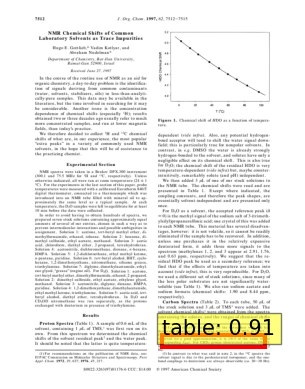

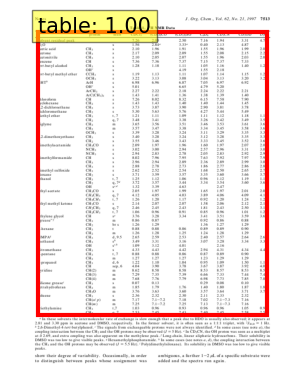

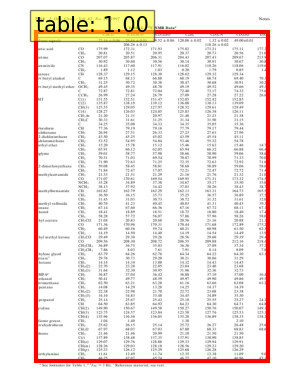

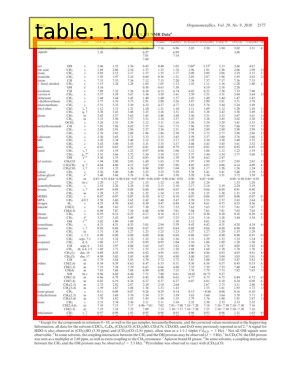

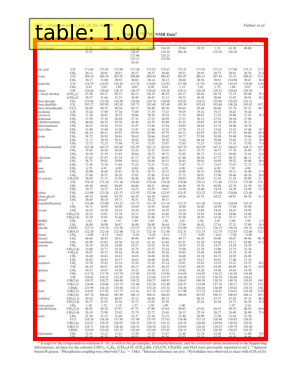

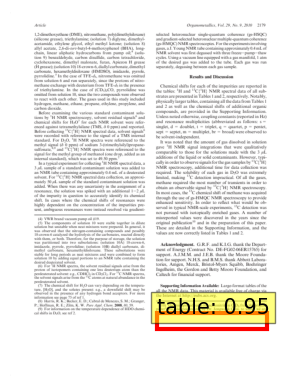

In [121]:
# display several images
for table in tables:
    table.visualize(figsize=None)

Invoking large table row guess! set TATRFormatConfig.force_large_table_assumption to False to disable this.


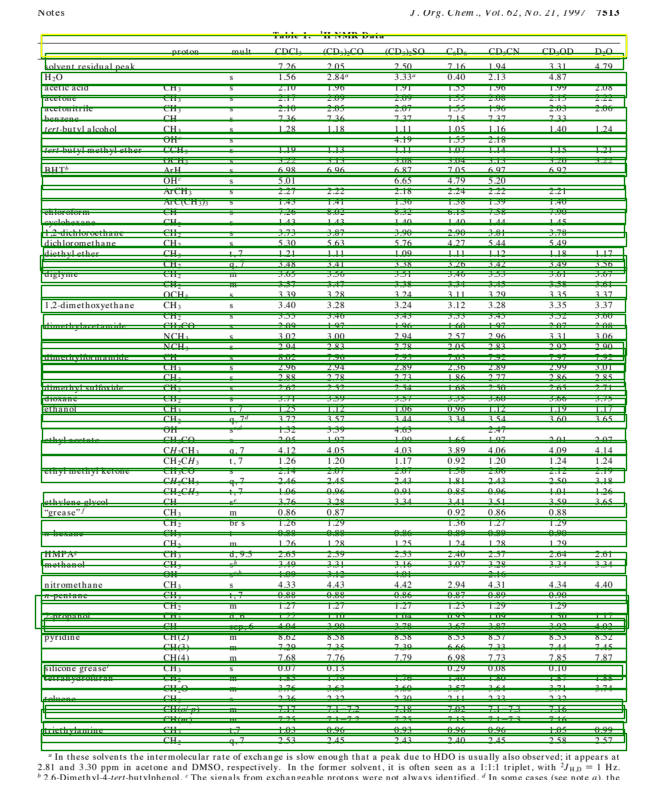

In [138]:
# 4s
ft1 = formatter.extract(tables[1])
ft1.visualize(filter=[2,3], show_labels=False, margin='auto', figsize=(16, 10), linewidth=1)

TATR's row detection may struggle for large tables. Thus, for large tables gmft uses a procedural algorithm which takes advantage of the greater number of rows. This is called the **large table assumption**, and it can be configured on/off.

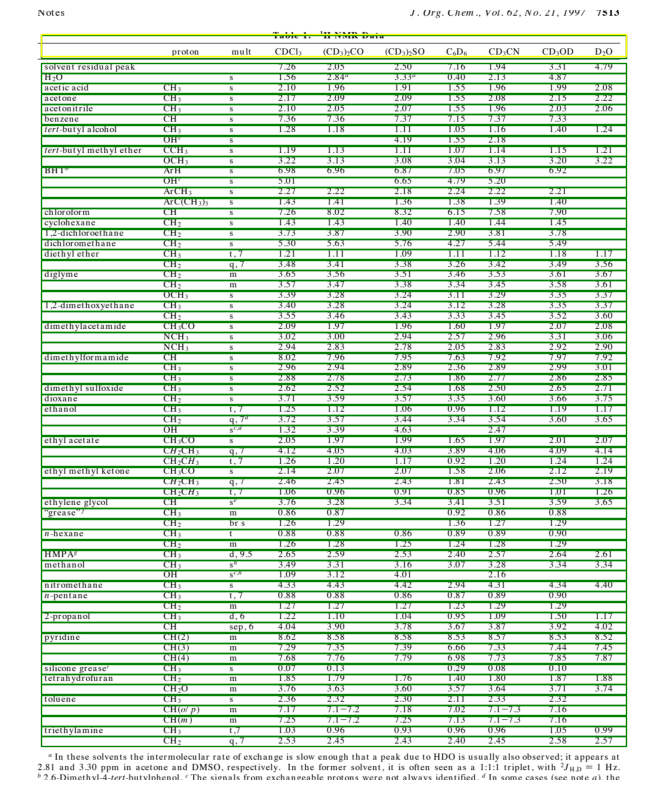

In [140]:
ft1.visualize(filter=[2,3], effective=True, margin='auto', figsize=(16, 10), show_labels=False, linewidth=1)

In [126]:
import pandas as pd
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(ft1.df().fillna(""))

pr ot on   m ult CDCl3       (CD3)2CO  \
0        solvent r esidu al pea k                     7.26           2.05   
1                             H2O                  s  1.56          2.84a   
2                   a cetic a cid        CH3       s  2.10           1.96   
3                      a cet on e        CH3       s  2.17           2.09   
4                 a cet onit rile        CH3       s  2.10           2.05   
5                         benzene         CH       s  7.36           7.36   
6            tert-but yl alcoh ol        CH3       s  1.28           1.18   
7                                        OHc       s                        
8   tert-but yl m et h yl et h er       CCH3       s  1.19           1.13   
9                                       OCH3       s  3.22           3.13   
10                           BHTb        ArH       s  6.98           6.96   
11                                       OHc       s  5.01                  
12                                     ArCH3       s  2.27           2.22   
13                                 ArC(CH3)3       s  1.43           1.41   
14                    chlor oform         CH       s  7.26           8.02   
15                 cycloh exa n e        CH2       s  1.43           1.43   
16        1,2-dichlor oet h a n e        CH2       s  3.73           3.87   
17          dichlor om et h a n e        CH2       s  5.30           5.63   
18                  diethyl ether        CH3    t, 7  1.21           1.11   
19                                       CH2    q, 7  3.48           3.41   
20                        diglyme        CH2       m  3.65           3.56   
21                                       CH2       m  3.57           3.47   
22                                      OCH3       s  3.39           3.28   
23     1,2-dim et h oxyet h a n e        CH3       s  3.40           3.28   
24                                       CH2       s  3.55           3.46   
25         dim et h yla cet amide      CH3CO       s  2.09           1.97   
26                                      NCH3       s  3.02           3.00   
27                                      NCH3       s  2.94           2.83   
28          dim et h ylform amide         CH       s  8.02           7.96   
29                                       CH3       s  2.96           2.94   
30                                       CH3       s  2.88           2.78   
31          dim et h yl sulfoxide        CH3       s  2.62           2.52   
32                      dioxa n e        CH2       s  3.71           3.59   
33                    et h a n ol        CH3    t, 7  1.25           1.12   
34                                       CH2   q, 7d  3.72           3.57   
35                                        OH    sc,d  1.32           3.39   
36             et h yl a cet at e      CH3CO       s  2.05           1.97   
37                                    CH2CH3    q, 7  4.12           4.05   
38                                    CH2CH3    t, 7  1.26           1.20   
39     et h yl m et h yl ket on e      CH3CO       s  2.14           2.07   
40                                    CH2CH3    q, 7  2.46           2.45   
41                                    CH2CH3    t, 7  1.06           0.96   
42             et h ylen e glycol         CH      se  3.76           3.28   
43                   “gr ea se” f        CH3       m  0.86           0.87   
44                                       CH2    br s  1.26           1.29   
45                    n-h exa n e        CH3       t  0.88           0.88   
46                                       CH2       m  1.26           1.28   
47                          HMPAg        CH3  d, 9.5  2.65           2.59   
48                  m et h a n ol        CH3      sh  3.49           3.31   
49                                        OH    sc,h  1.09           3.12   
50            nit r om et h a n e        CH3       s  4.33           4.43   
51                   n-pent a n 

Usually, having an excess of rows is better than having too few rows. This is because gmft will prune empty rows, while too few rows means that rows get merged.

The image -> df step is heavily dependent on padding (see [this issue](https://github.com/microsoft/table-transformer/issues/158)). Therefore, it may be worth adjusting the padding if you get an unfavorable result. 

New in `v0.2`, setting `margin='auto', padding=None` will include 30 pixels of the pdf on all sides, which is used by PubTables-1M authors. I find that this can make a difference for large tables.

Invoking large table row guess! set TATRFormatConfig.force_large_table_assumption to False to disable this.


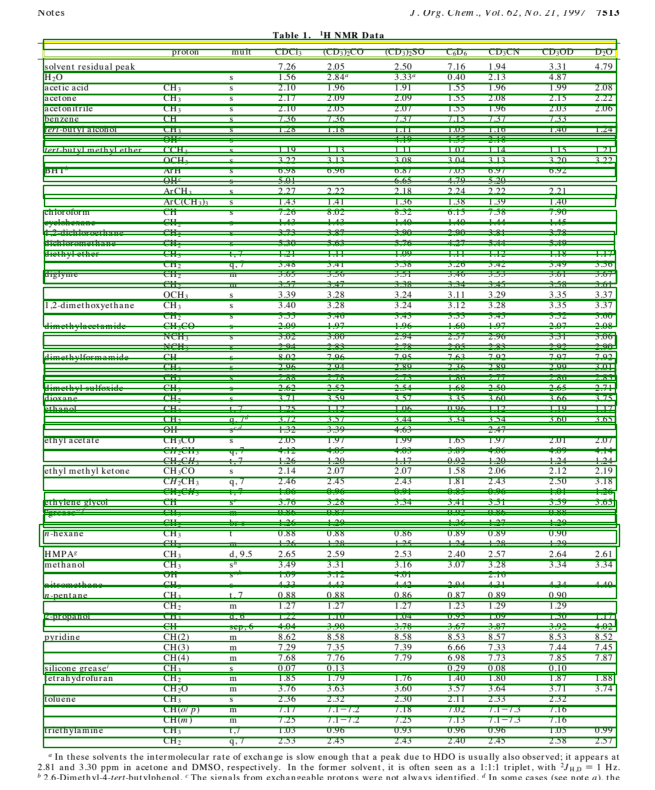

In [142]:
ft1 = formatter.extract(tables[1], margin='auto', padding=None)
ft1.visualize(filter=[2,3], effective=False, margin='auto', figsize=(16, 10), show_labels=False, linewidth=1)

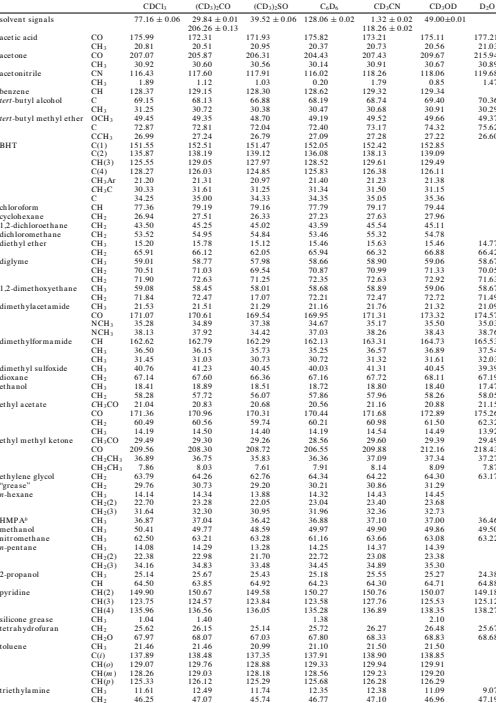

Invoking large table row guess! set TATRFormatConfig.force_large_table_assumption to False to disable this.


CDCl3       (CD3)2CO  \
0                solvent sign als          77.16 ( 0.06   29.84 ( 0.01   
1                                                        206.26 ( 0.13   
2                   a cetic a cid      CO        175.99         172.31   
3                                     CH3         20.81          20.51   
4                      a cet on e      CO        207.07         205.87   
5                                     CH3         30.92          30.60   
6                 a cet onit rile      CN        116.43         117.60   
7                                     CH3          1.89           1.12   
8                         benzene      CH        128.37         129.15   
9            tert-but yl alcoh ol       C         69.15          68.13   
10                                    CH3         31.25          30.72   
11  tert-but yl m et h yl et h er    OCH3         49.45          49.35   
12                                      C         72.87          72.81   
13                                   CCH3         26.99          27.24   
14                            BHT    C(1)        151.55         152.51   
15                                   C(2)        135.87         138.19   
16                                 CH (3)        125.55         129.05   
17                                   C(4)        128.27         126.03   
18                                  CH3Ar         21.20          21.31   
19                                   CH3C         30.33          31.61   
20                                      C         34.25          35.00   
21                    chlor oform      CH         77.36          79.19   
22                 cycloh exa n e     CH2         26.94          27.51   
23        1,2-dichlor oet h a n e     CH2         43.50          45.25   
24          dichlor om et h a n e     CH2         53.52          54.95   
25                  diethyl ether     CH3         15.20          15.78   
26                                    CH2         65.91          66.12   
27                        diglyme     CH3         59.01          58.77   
28                                    CH2         70.51          71.03   
29                                    CH2         71.90          72.63   
30     1,2-dim et h oxyet h a n e     CH3         59.08          58.45   
31                                    CH2         71.84          72.47   
32         dim et h yla cet amide     CH3         21.53          21.51   
33                                     CO        171.07         170.61   
34                                   NCH3         35.28          34.89   
35                                   NCH3         38.13          37.92   
36          dim et h ylform amide      CH        162.62         162.79   
37                                    CH3         36.50          36.15   
38                                    CH3         31.45          31.03   
39          dim et h yl sulfoxide     CH3         40.76          41.23   
40                      dioxa n e     CH2         67.14          67.60   
41                    et h a n ol     CH3         18.41          18.89   
42                                    CH2         58.28          57.72   
43             et h yl a cet at e   CH3CO         21.04          20.83   
44                                     CO        171.36         170.96   
45                                    CH2         60.49          60.56   
46                                    CH3         14.19          14.50   
47     et h yl m et h yl ket on e   CH3CO         29.49          29.30   
48                                     CO        209.56         208.30   
49                                 CH2CH3         36.89          36.75   
50                                 CH2CH3          7.86           8.03   
51             et h ylen e glycol     CH2         63.79          64.26   
52                     “gr ea se”     CH2         29.76          30.73   
53                    n-h exa n e     CH3         14.1

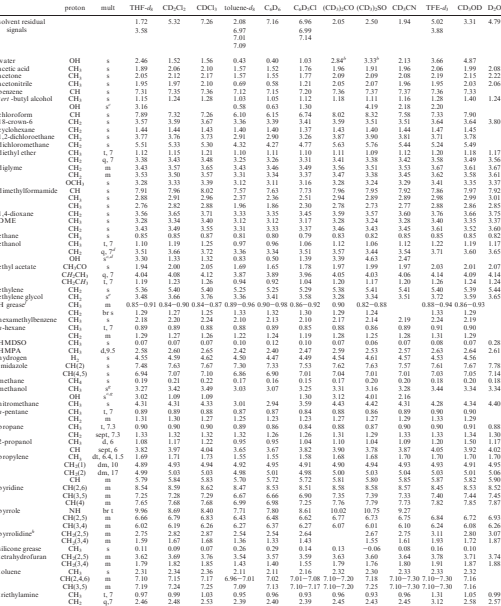

Invoking large table row guess! set TATRFormatConfig.force_large_table_assumption to False to disable this.


proton          mult     THF-d8     CD2Cl2  \
0      solvent residual                                1.72       5.32   
1               signals                                3.58              
2                                                                        
3                                                                        
4                 water         OH             s       2.46       1.52   
5           acetic acid        CH3             s       1.89       2.06   
6               acetone        CH3             s       2.05       2.12   
7          acetonitrile        CH3             s       1.95       1.97   
8               benzene         CH             s       7.31       7.35   
9   tert -butyl alcohol        CH3             s       1.15       1.24   
10                              OH            sc       3.16              
11           chloroform         CH             s       7.89       7.32   
12           18-crown-6        CH2             s       3.57       3.59   
13          cyclohexane        CH2             s       1.44       1.44   
14   1,2-dichloroethane        CH2             s       3.77       3.76   
15      dichloromethane        CH2             s       5.51       5.33   
16        diethyl ether        CH3          t, 7       1.12       1.15   
17                             CH2          q, 7       3.38       3.43   
18              diglyme        CH2             m       3.43       3.57   
19                             CH2             m       3.53       3.50   
20                            OCH3             s       3.28       3.33   
21    dimethylformamide         CH             s       7.91       7.96   
22                             CH3             s       2.88       2.91   
23                             CH3             s       2.76       2.82   
24          1,4-dioxane        CH2             s       3.56       3.65   
25                  DME        CH3             s       3.28       3.34   
26                             CH2             s       3.43       3.49   
27               ethane        CH3             s       0.85       0.85   
28              ethanol        CH3          t, 7       1.10       1.19   
29                             CH2         q, 7d       3.51       3.66   
30                              OH          sc,d       3.30       1.33   
31        ethyl acetate      CH3CO             s       1.94       2.00   
32                          CH2CH3          q, 7       4.04       4.08   
33                          CH2CH3          t, 7       1.19       1.23   
34             ethylene        CH2             s       5.36       5.40   
35      ethylene glycol        CH2           s e       3.48       3.66   
36            H greasef        CH3             m  0.85-0.91  0.84-0.90   
37                             CH2          br s       1.29       1.27   
38    hexamethylbenzene        CH3             s       2.18       2.20   
39             n-hexane        CH3          t, 7       0.89       0.89   
40                             CH2             m       1.29       1.27   
41                HMDSO        CH3             s       0.07       0.07   
42                 HMPA        CH3         d,9.5       2.58       2.60   
43             hydrogen         H2             s       4.55       4.59   
44            imidazole      CH(2)             s       7.48       7.63   
45                         CH(4,5)             s       6.94       7.07   
46              methane        CH4             s       0.19       0.21   
47             methanol        CH3           s g       3.27       3.42   
48                              OH          sc,g       3.02       1.09   
49         nitromethane        CH3             s       4.31       4.31   
50            n-pentane        CH3          t, 7       0.89       0.89   
51                             CH2             m       1.31       1.30   
52              propane        CH3        t, 7.3       0.90       0.90   
53                             C

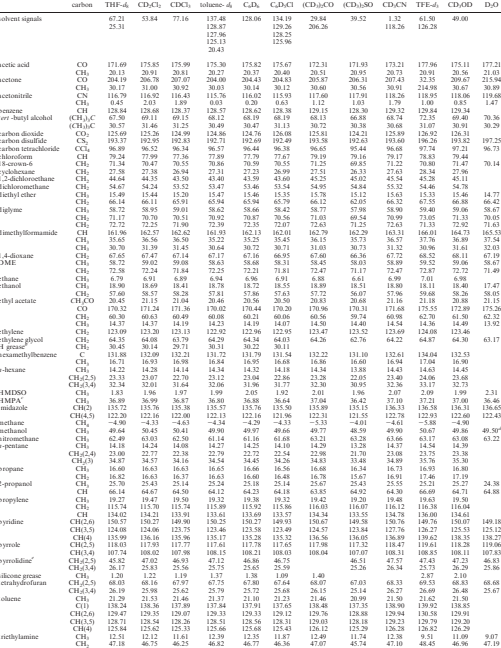

Invoking large table row guess! set TATRFormatConfig.force_large_table_assumption to False to disable this.


carbon  THF-d8  CD2Cl2   CDCl3 toluene- d8 C6D6    \
0        solvent signals             67.21   53.84   77.16   137.48  128.06     
1                                    25.31                   128.87             
2                                                            127.96             
3                                                            125.13             
4                                                             20.43             
5            acetic acid        CO  171.69  175.85  175.99   175.30  175.82     
6                              CH3   20.13   20.91   20.81    20.27   20.37     
7                acetone        CO  204.19  206.78  207.07   204.00  204.43     
8                              CH3   30.17   31.00   30.92    30.03   30.14     
9           acetonitrile        CN  116.79  116.92  116.43   115.76  116.02     
10                             CH3    0.45    2.03    1.89     0.03    0.20     
11               benzene        CH  128.84  128.68  128.37   128.57  128.62     
12   tert -butyl alcohol   (CH3)3C   67.50   69.11   69.15    68.12   68.19     
13                         (CH3)3C   30.57   31.46   31.25    30.49   30.47     
14        carbon dioxide       CO2  125.69  125.26  124.99   124.86  124.76     
15      carbon disulfide       CS2  193.37  192.95  192.83   192.71  192.69     
16  carbon tetrachloride      CCl4   96.89   96.52   96.34    96.57   96.44     
17            chloroform        CH   79.24   77.99   77.36    77.89   77.79     
18            18-crown-6       CH2   71.34   70.47   70.55    70.86   70.59     
19           cyclohexane       CH2   27.58   27.38   26.94    27.31   27.23     
20    1,2-dichloroethane       CH2   44.64   44.35   43.50    43.40   43.59     
21       dichloromethane       CH2   54.67   54.24   53.52    53.47   53.46     
22         diethyl ether       CH3   15.49   15.44   15.20    15.47   15.46     
23                             CH2   66.14   66.11   65.91    65.94   65.94     
24               diglyme       CH3   58.72   58.95   59.01    58.62   58.66     
25                             CH2   71.17   70.70   70.51    70.92   70.87     
26                             CH2   72.72   72.25   71.90    72.39   72.35     
27     dimethylformamide        CH  161.96  162.57  162.62   161.93  162.13     
28                             CH3   35.65   36.56   36.50    35.22   35.25     
29                             CH3   30.70   31.39   31.45    30.64   30.72     
30           1,4-dioxane       CH2   67.65   67.47   67.14    67.17   67.16     
31                   DME       CH3   58.72   59.02   59.08    58.63   58.68     
32                             CH2   72.58   72.24   71.84    72.25   72.21     
33                ethane       CH3    6.79    6.91    6.89     6.94    6.96     
34               ethanol       CH3   18.90   18.69   18.41    18.78   18.72     
35                             CH2   57.60   58.57   58.28    57.81   57.86     
36         ethyl acetate     CH3CO   20.45   21.15   21.04    20.46   20.56     
37                              CO  170.32  171.24  171.36   170.02  170.44     
38                             CH2   60.30   60.63   60.49    60.08   60.21     
39                             CH3   14.37   14.37   14.19    14.23   14.19     
40              ethylene       CH2  123.09  123.20  123.13   122.92  122.96     
41       ethylene glycol       CH2   64.35   64.08   63.79    64.29   64.34     
42             H greaseb       CH2   30.45   30.14   29.71    30.31   30.22     
43     hexamethylbenzene         C  131.88  132.09  132.21   131.72  131.79     
44                             CH3   16.71   16.93   16.98    16.84   16.95     
45              n-hexane       CH3   14.22   14.28   14.14    14.34   14.32     
46                        CH2(2,5)   23.33   23.07   22.70    23.12   23.04     
47                        CH2(3,4)   32.34   32.01   31.64    32.06   31.96     
48                 HMDSO       CH3    1.83    1.96    1.97 

In [146]:
for i in range(2, 5):
    ft = formatter.extract(tables[i])
    display(ft.image())
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        display(ft.df().fillna(""))

By default, **large table assumption** activates under these conditions:

At least one of these:
- More than `large_table_if_n_rows_removed` rows are removed (default: >= 8)
- OR all of the following are true:
    - Measured overlap of rows exceeds `large_table_row_overlap_threshold` (default: 20%)
    - AND the number of rows is greater than `large_table_threshold` (default: >= 10)

Large table assumption can be directly turned on/off with `config.large_table_assumption = True/False`.

The warning can be turned off with `config.verbosity = 0`

Invoking large table row guess! set TATRFormatConfig.force_large_table_assumption to False to disable this.


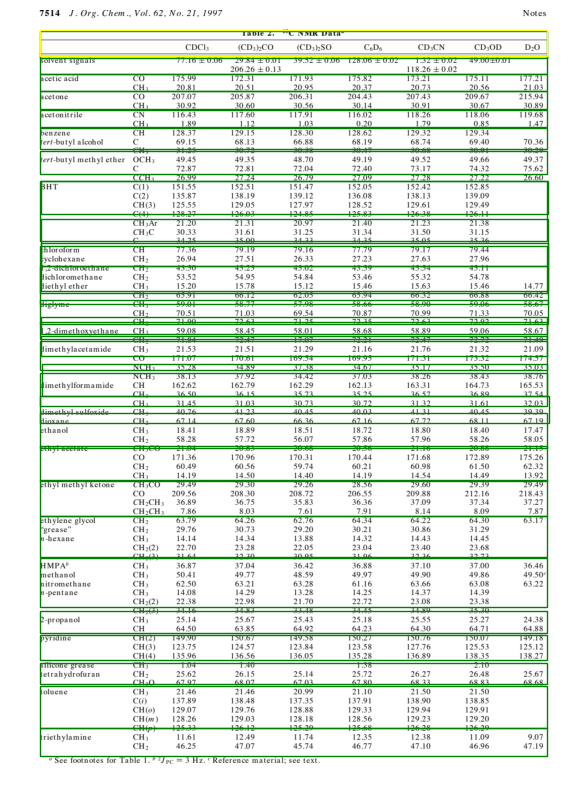

None

\
0                              solvent sign als                          
1                                 a cetic a cid                 CO CH3   
2                                    a cet on e                 CO CH3   
..                                          ...                    ...   
20  silicon e gr ea se t et r a h ydr ofu r a n           CH3 CH2 CH2O   
21                                   t olu en e  CH3 C(i) CH(o) CH(m )   
22                                triethylamine          CH(p) CH3 CH2   

                         CDCl3  ...                       CD3CN  \
0                 77.16 ( 0.06  ...   1.32 ( 0.02 118.26 ( 0.02   
1                 175.99 20.81  ...                173.21 20.73   
2                 207.07 30.92  ...                207.43 30.91   
..                         ...  ...                         ...   
20            1.04 25.62 67.97  ...                 26.27 68.33   
21  21.46 137.89 129.07 128.26  ...  21.50 138.90 129.94 129.23   
22          125.33 11.61 46.25  ...          126.28 12.38 47.10   

                         CD3OD           D2O  
0                   49.00(0.01                
1                 175.11 20.56  177.21 21.03  
2                 209.67 30.67  215.94 30.89  
..                         ...           ...  
20            2.10 26.48 68.83   25.67 68.68  
21  21.50 138.85 129.91 129.20                
22          126.29 11.09 46.96    9.07 47.19  

[23 rows x 9 columns]

In [150]:
from gmft.table_function import TATRFormatConfig


config = TATRFormatConfig()
config.verbosity = 0
# config.force_large_table_assumption = True # forces it to always run
config.force_large_table_assumption = False # forces it to never run
ft = formatter.extract(tables[2])
display(ft.visualize(filter=[2,3], effective=False, margin='auto', figsize=(16, 10), show_labels=False, linewidth=1))
with pd.option_context('display.max_rows', 6, 'display.max_columns', 6):
    display(ft.df(config_overrides=config).fillna(""))

Also, be warned that false positives are be observed more often for rotated tables ( where `table.label == 1`)

Finally, useful outlier/warning information may be stored in `ft.outliers`.

In [130]:
ft.outliers

{'nms removed rows': 11}

In [35]:
doc.close()

### Addendum: Benchmarks

This is run on Google Colab's **cpu**.

In [38]:
import time
_total_detect_time = 0
_total_detect_num = 0
_total_format_time = 0
_total_format_num = 0

for paper in ['tatr.pdf', 'attention.pdf', 'nmr.pdf']:
  start = time.time()
  tables, doc = ingest_pdf('./samples/' + paper)
  num_pages = len(doc)
  end_detect = time.time()
  for table in tables:
    tf = formatter.extract(table)
  end_format = time.time()
  doc.close()
  print(f"Paper: {paper}\nDetect time: {end_detect - start:.3f}s for {num_pages} pages")
  print(f"Format time: {end_format - end_detect:.3f}s for {len(tables)} tables\n")
  _total_detect_time += end_detect - start
  _total_detect_num += num_pages
  _total_format_time += end_format - end_detect
  _total_format_num += len(tables)
print(f"Macro: {_total_detect_time/_total_detect_num:.3f} s/page and {_total_format_time/_total_format_num:.3f} s/table ")

Paper: 2110.00061.pdf
Detect time: 13.730s for 10 pages
Format time: 4.247s for 6 tables

Paper: attention.pdf
Detect time: 21.085s for 15 pages
Format time: 4.801s for 5 tables

Paper: nmr.pdf
Detect time: 12.152s for 9 pages
Format time: 6.071s for 5 tables

Macro: 1.381 s/page and 0.945 s/table 
